In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
import math as ma

In [2]:
# TASK 1

mu1 = 4902.8;
T = 2332800;
a1=(mu1*(T/(2*(np.pi)))**2)**(1./3.)
print("The semi-major axis a=",a1,"km")
amoon = 348400;
emoon = 0.0549;
Mmoon = 7.3477*(10**22);
Mearth = 5.972*(10**24);

rh = amoon*(1 - emoon)*(Mmoon/(3*Mearth))**(1./3.)
print("Moon’s Hill’s radius =",rh,"km")

# Παρατηρούμε ότι ο μεγάλος ημιάξονας της τροχιάς, α, είναι λίγο μεγαλύτερος σε μήκος από ότι η ακτίνα του Hill γεγονός το οποίο
# είναι λογικό.

The semi-major axis a= 87756.60590065194 km
Moon’s Hill’s radius = 52705.91576823092 km


In [28]:
# TASK 2

%reset -f

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
import math as ma


a0=5737.4;
e0=0.61;
i0=57.82;
Ω0=0;
ω0=90;
f0=0;
R_moon=1738.1;

In [29]:
t0 = 0.0;
tmax = 2332800;
mu=a0*a0*a0*(2*np.pi/tmax)**2


In [30]:
#Convert Keplerian elements to Cartesian.
def kep2cart(kep, GM):
    a,e,i,Om,w,f = kep
    p = a*(1-e*e)
    sqrt_GM = np.sqrt(GM/p)
    
    sini, cosi = np.sin(i), np.cos(i)
    sinOm, cosOm = np.sin(Om), np.cos(Om)
    sinw, cosw = np.sin(w), np. cos(w)
    sinf, cosf = np.sin(f), np.cos(f)
    
    rx = p*cosf/(1+e*cosf)
    ry = p*sinf/(1+e*cosf)
    v_x = -sqrt_GM*sinf
    v_y = sqrt_GM*(e+cosf)
    
    R11 = cosOm*cosw - sinOm*cosi*sinw
    R12 = -cosOm*sinw - cosw*cosi*sinOm
    R13 = sini*sinOm
    
    R21 = sinOm*cosw + cosOm*cosi*sinw
    R22 = -sinOm*sinw + cosOm*cosi*cosw
    R23 = -sini*cosOm
    
    R31 = sini*sinw
    R32 = sini*cosw
    R33 = cosi
    
    x = R11*rx + R12*ry
    y = R21*rx + R22*ry
    z = R31*rx + R32*ry
    vx = R11*v_x + R12*v_y
    vy = R21*v_x + R22*v_y
    vz = R31*v_x + R32*v_y
    
    return [x,y,z,vx,vy,vz]

In [31]:
#Convert Cartesian elements to Keplerian.
def cart2kep(cart, GM):
    x,y,z,vx,vy,vz = cart
    eps = 1e-14
    r = np.sqrt(x*x+y*y+z*z)
    rx = x
    ry = y 
    rz = z
    v = np.sqrt(vx*vx+vy*vy+vz*vz)
    E = (1/2)*v*v  - (mu/r)
    a = -mu/(2*E)
    hx = y*vz - z*vy
    hy = -x*vz + z*vx
    hz = x*vy - y*vx
    h = np.sqrt(hx*hx+hy*hy+hz*hz)
    i = np.arccos(hz/h)
    ex = (1/mu)*((v*v-mu/r)*rx - (rx*vx + ry*vy + rz*vz)*vx)
    ey = (1/mu)*((v*v-mu/r)*ry - (rx*vx + ry*vy + rz*vz)*vy)
    ez = (1/mu)*((v*v-mu/r)*rz - (rx*vx + ry*vy + rz*vz)*vz)
    e = np.sqrt(ex*ex+ey*ey+ez*ez)
    nx = -hy
    ny = hx
    nz = 0
    n = np.sqrt(nx*nx+ny*ny+nz*nz)
    
    if ny>=0:
        Om = np.arccos(nx/n)
        
    if ny<0:
        Om = 2*np.pi - np.arccos(nx/n)
    
    if e>eps:
        if n>eps:
            w = np.arccos((nx*ex+ny*ey)/n*e)
        if ez<0:
            w = 2*np.pi - np.arccos((nx*ex+ny*ey)/n*e)
   
    v_r = (x*vx+y*vy+z*vz)/r
    
    
    if v_r>=0:
        f = np.arccos((ex*rx+ey*ry+ez*rz)/(e*r))
                      
    if v_r<0:
        f = 2*np.pi - np.arccos((ex*rx+ey*ry+ez*rz)/(e*r))        
     
        
    
    return [a,e,i,Om,w,f]

In [32]:
IC = [ a0 , e0, np.deg2rad(i0), np.deg2rad(Ω0), np.deg2rad(ω0), f0 ];
ICCAR = kep2cart(IC,mu);

In [33]:
def rhs_2bp(t , X):
    x, y, z, vx, vy, vz = X
    r = np.sqrt(x**2+y**2+z**2)
    r3 = r*r*r
    x_dot = vx
    y_dot = vy
    z_dot = vz
    vx_dot = - mu*x/r3 
    vy_dot = - mu*y/r3 
    vz_dot = - mu*z/r3 
    return [x_dot, y_dot, z_dot, vx_dot, vy_dot, vz_dot]

In [34]:
# solve 2-body problem in cartesian coordinates
sol = solve_ivp(rhs_2bp, [t0, tmax], ICCAR ,t_eval=np.linspace(0,tmax,500),method='DOP853',atol=1e-13,rtol=1e-13)

celem = [];
for i in range(0, len(sol.t)):
    car = sol.y[:,i]
    coe = cart2kep(car,mu)
    r1 = np.array(np.sqrt((np.array(sol.y[0]))**2 + (np.array(sol.y[1]))**2 + (np.array(sol.y[2]))**2))
    R = r1 - R_moon
    celem.append(coe)
solcoe = np.transpose(np.array(celem))


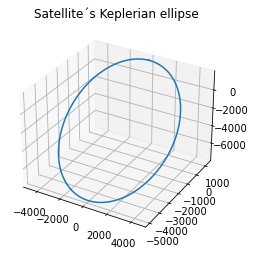

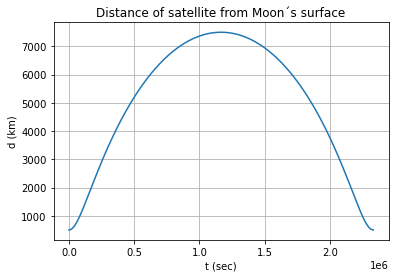

In [35]:
t_eval=np.linspace(0,tmax,500)

fig = plt.figure(figsize=(4,4))

ax = fig.add_subplot(111, projection='3d')
plt.figure(1)
ax.plot(sol.y[0],sol.y[1],sol.y[2])
plt.title('Satellite΄s Keplerian ellipse')
plt.show()

plt.figure(2)
plt.plot(t_eval,R)
plt.title('Distance of satellite from Moon΄s surface')
plt.xlabel('t (sec)')
plt.ylabel('d (km)')
plt.grid()
plt.show()




In [36]:
# B. Propagation of orbital state of the satellite for t_end=30 days

%reset -f

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
import math as ma

a0=5737.4;
e0=0.61;
i0=57.82;
Ω0=0;
ω0=90;
f0=0;
R_moon=1738.1;


t0=0;
tmax2 = 2592000; #30 days
mu=4902.8

#Convert Keplerian elements to Cartesian.
def kep2cart(kep, GM):
    a,e,i,Om,w,f = kep
    p = a*(1-e*e)
    sqrt_GM = np.sqrt(GM/p)
    
    sini, cosi = np.sin(i), np.cos(i)
    sinOm, cosOm = np.sin(Om), np.cos(Om)
    sinw, cosw = np.sin(w), np. cos(w)
    sinf, cosf = np.sin(f), np.cos(f)
    
    rx = p*cosf/(1+e*cosf)
    ry = p*sinf/(1+e*cosf)
    v_x = -sqrt_GM*sinf
    v_y = sqrt_GM*(e+cosf)
    
    R11 = cosOm*cosw - sinOm*cosi*sinw
    R12 = -cosOm*sinw - cosw*cosi*sinOm
    R13 = sini*sinOm
    
    R21 = sinOm*cosw + cosOm*cosi*sinw
    R22 = -sinOm*sinw + cosOm*cosi*cosw
    R23 = -sini*cosOm
    
    R31 = sini*sinw
    R32 = sini*cosw
    R33 = cosi
    
    x = R11*rx + R12*ry
    y = R21*rx + R22*ry
    z = R31*rx + R32*ry
    vx = R11*v_x + R12*v_y
    vy = R21*v_x + R22*v_y
    vz = R31*v_x + R32*v_y
    
    return [x,y,z,vx,vy,vz]

#Convert Cartesian elements to Keplerian.
def cart2kep(cart, GM):
    x,y,z,vx,vy,vz = cart
    eps = 1e-14
    r = np.sqrt(x*x+y*y+z*z)
    rx = x
    ry = y 
    rz = z
    v = np.sqrt(vx*vx+vy*vy+vz*vz)
    E = (1/2)*v*v  - (mu/r)
    a = -mu/(2*E)
    hx = y*vz - z*vy
    hy = -x*vz + z*vx
    hz = x*vy - y*vx
    h = np.sqrt(hx*hx+hy*hy+hz*hz)
    i = np.arccos(hz/h)
    ex = (1/mu)*((v*v-mu/r)*rx - (rx*vx + ry*vy + rz*vz)*vx)
    ey = (1/mu)*((v*v-mu/r)*ry - (rx*vx + ry*vy + rz*vz)*vy)
    ez = (1/mu)*((v*v-mu/r)*rz - (rx*vx + ry*vy + rz*vz)*vz)
    e = np.sqrt(ex*ex+ey*ey+ez*ez)
    nx = -hy
    ny = hx
    nz = 0
    n = np.sqrt(nx*nx+ny*ny+nz*nz)
    
    if ny>=0:
        Om = np.arccos(nx/n)
        
    if ny<0:
        Om = 2*np.pi - np.arccos(nx/n)
    
    if e>eps:
        if n>eps:
            w = np.arccos((nx*ex+ny*ey)/n*e)
        if ez<0:
            w = 2*np.pi - np.arccos((nx*ex+ny*ey)/n*e)
   
    v_r = (x*vx+y*vy+z*vz)/r
    
    
    if v_r>=0:
        f = np.arccos((ex*rx+ey*ry+ez*rz)/(e*r))
                      
    if v_r<0:
        f = 2*np.pi - np.arccos((ex*rx+ey*ry+ez*rz)/(e*r))        
     
        
    
    return [a,e,i,Om,w,f]

IC = [ a0 , e0, np.deg2rad(i0), np.deg2rad(Ω0), np.deg2rad(ω0), f0 ];
ICCAR = kep2cart(IC,mu);

def rhs_2bp(t , X):
    x, y, z, vx, vy, vz = X
    r = np.sqrt(x**2+y**2+z**2)
    r3 = r*r*r
    x_dot = vx
    y_dot = vy
    z_dot = vz
    vx_dot = - mu*x/r3 
    vy_dot = - mu*y/r3 
    vz_dot = - mu*z/r3 
    return [x_dot, y_dot, z_dot, vx_dot, vy_dot, vz_dot]


# solve 2-body problem in cartesian coordinates
sol = solve_ivp(rhs_2bp, [t0, tmax2], ICCAR ,t_eval=np.linspace(0,tmax2,500),method='DOP853',atol=1e-13,rtol=1e-13)

celem = [];
for i in range(0, len(sol.t)):
    car = sol.y[:,i]
    coe = cart2kep(car,mu)
    celem.append(coe)
solcoe = np.transpose(np.array(celem))

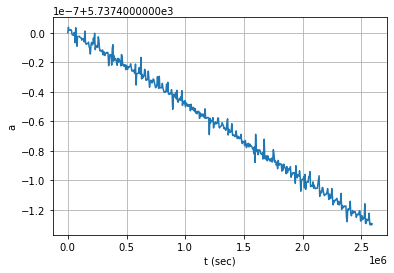

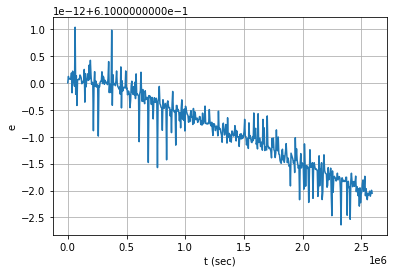

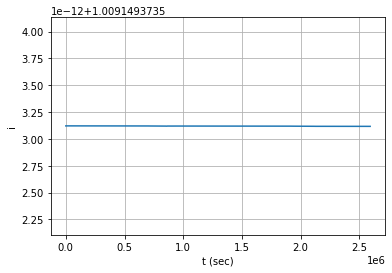

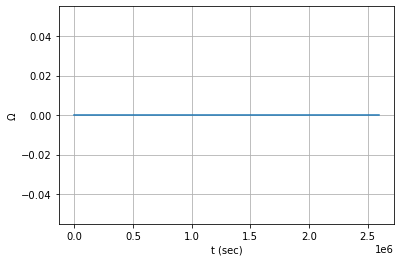

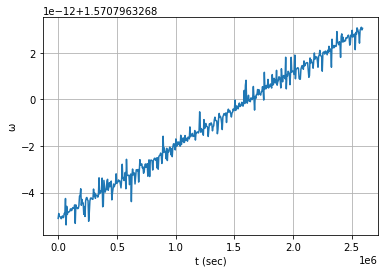

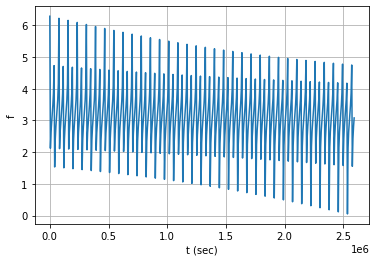

In [37]:
plt.figure(1)
plt.plot(sol.t,solcoe[0])
plt.xlabel('t (sec)')
plt.ylabel('a')
plt.grid()
plt.show()
plt.figure(2)
plt.plot(sol.t,solcoe[1])
plt.xlabel('t (sec)')
plt.ylabel('e')
plt.grid()
plt.show()
plt.figure(3)
plt.plot(sol.t,solcoe[2])
plt.xlabel('t (sec)')
plt.ylabel('i')
plt.grid()
plt.show()
plt.figure(4)
plt.plot(sol.t,solcoe[3])
plt.xlabel('t (sec)')
plt.ylabel('Ω')
plt.grid()
plt.show()
plt.figure(5)
plt.plot(sol.t,solcoe[4])
plt.xlabel('t (sec)')
plt.ylabel('ω')
plt.grid()
plt.show()
plt.figure(6)
plt.plot(sol.t,solcoe[5])
plt.xlabel('t (sec)')
plt.ylabel('f')
plt.grid()
plt.show()



In [39]:
kep=a0,e0,i0,Ω0,ω0,f0
A=kep2cart(kep, mu)
cart1=A[0],A[1],A[2],A[3],A[4],A[5]
C=cart2kep(cart1,mu)

print("a= ",C[0])
print("e= ",C[1])
print("i= ",C[2])
print("Ω= ",C[3])
print("ω= ",C[4])
print("f= ",solcoe[5])

a=  5737.399999999998
e=  0.6099999999999998
i=  1.271332235383722
Ω=  0.0
ω=  1.738306804990018
f=  [6.28318531 2.1204487  2.63641576 2.94489213 3.20472383 3.47887056
 3.85307058 4.7258117  1.53128182 2.42276063 2.79975384 3.07459229
 3.33421902 3.64129619 4.15110909 6.21771612 2.10861102 2.63090419
 2.94080809 3.20085758 3.47432936 3.8457957  4.70051839 1.50435373
 2.41532532 2.79517285 3.07071997 3.3301545  3.63586026 4.13968473
 6.15245875 2.09655586 2.62535363 2.93671395 3.19699409 3.46980749
 3.83859811 4.67598749 1.47654978 2.40780674 2.79057136 3.06684434
 3.32609938 3.63046103 4.12845683 6.08762036 2.08427555 2.61976327
 2.93260944 3.19313318 3.46530456 3.83147595 4.6521846  1.44782863
 2.40020277 2.785949   3.06296521 3.32205344 3.62509774 4.117419
 6.02339913 2.07176208 2.61413227 2.92849434 3.18927466 3.46082022
 3.8244274  4.62907703 1.41814723 2.39251121 2.78130533 3.0590824
 3.31801644 3.6197697  4.1065651  5.9599803  2.05900704 2.60845981
 2.92436838 3.18541836 3.456354

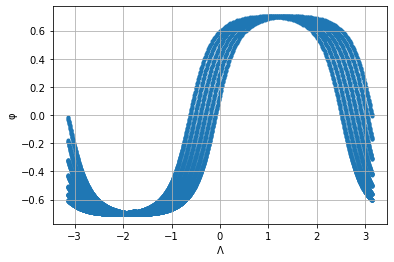

In [25]:
# C. Ground-track of the satellite for 3 days

%reset -f

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import math as ma

a0=5737.4
e0=0.61
i0=57.82
Om0=0
w0=90
f0=0
R_moon=1738.1
w_moon=2.66186*(10**(-6))

t0=0
tmax1 = 3*86400 #3 days
#tmax2 = 2592000; #30 days
mu=4902.8


#Convert Keplerian elements to Cartesian.
def kep2cart(kep, GM):
    a,e,i,Om,w,f = kep
    p = a*(1-e*e)
    sqrt_GM = np.sqrt(GM/p)
    
 #   sini, cosi = np.sin(i), np.cos(i)
#    sinOm, cosOm = np.sin(Om), np.cos(Om)
#    sinw, cosw = np.sin(w), np.cos(w)
#    sinf, cosf = np.sin(f), np.cos(f)
    
    rx = p*np.cos(f)/(1+e*np.cos(f))
    ry = p*np.sin(f)/(1+e*np.cos(f))
    v_x = -sqrt_GM*np.sin(f)
    v_y = sqrt_GM*(e+np.cos(f))
    
    R11 = np.cos(Om)*np.cos(w) - np.sin(Om)*np.cos(i)*np.sin(w)
    R12 = -np.cos(Om)*np.sin(w) - np.cos(w)*np.cos(i)*np.sin(Om)
    R13 = np.sin(i)*np.sin(Om)
    
    R21 = np.sin(Om)*np.cos(w) + np.cos(Om)*np.cos(i)*np.sin(w)
    R22 = -np.sin(Om)*np.sin(w) + np.cos(Om)*np.cos(i)*np.cos(w)
    R23 = -np.sin(i)*np.cos(Om)
    
    R31 = np.sin(i)*np.sin(w)
    R32 = np.sin(i)*np.cos(w)
    R33 = np.cos(i)
    
    x = float(R11*rx + R12*ry)
    y = float(R21*rx + R22*ry)
    z = float(R31*rx + R32*ry)
    vx = float(R11*v_x + R12*v_y)
    vy = float(R21*v_x + R22*v_y)
    vz = float(R31*v_x + R32*v_y)
    
    return [x,y,z,vx,vy,vz]


IC = [ a0 , e0, np.deg2rad(i0), np.deg2rad(Om0), np.deg2rad(w0), f0 ];
ICCAR = kep2cart(IC,mu);

def rhs_2bp(t , X):
    x, y, z, vx, vy, vz = X
    r = np.sqrt(x**2+y**2+z**2)
    r3 = r*r*r
    x_dot = vx
    y_dot = vy
    z_dot = vz
    vx_dot = -(mu*x)/r3 
    vy_dot = -(mu*y)/r3 
    vz_dot = -(mu*z)/r3 
    return [x_dot, y_dot, z_dot, vx_dot, vy_dot, vz_dot]

lambda_ECEF=[]
phi_ECEF=[]


# solve 2-body problem in cartesian coordinates
sol = solve_ivp(rhs_2bp, [t0, tmax1], ICCAR ,t_eval=np.linspace(t0,tmax1,10000),method='DOP853',atol=1e-13,rtol=1e-13)

for i in range(0, len(sol.t)):
    theta_G1 =w_moon*sol.t[i]
    Rz = np.array([[np.cos(theta_G1),np.sin(theta_G1),0],[-np.sin(theta_G1),np.cos(theta_G1),0],[0,0,1]])
    rECEF= np.matmul(Rz,sol.y[:3,i])
    xECEF=np.array(rECEF[0])
    yECEF=np.array(rECEF[1])
    zECEF=np.array(rECEF[2])
    Lambda=np.arctan2(rECEF[1],rECEF[0])
    phi=np.arctan2(rECEF[2],(np.sqrt(rECEF[0]**2+rECEF[1]**2+rECEF[2]**2)))
    lambda_ECEF.append(Lambda)
    phi_ECEF.append(phi)
    

plt.figure()
plt.scatter(lambda_ECEF, phi_ECEF,marker='.')
plt.xlabel('Λ')
plt.ylabel('φ')
plt.grid()
plt.show()    


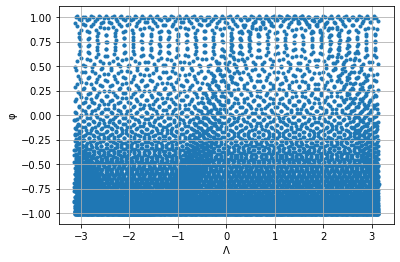

In [26]:
# C. Ground-track of the satellite for 30 days

%reset -f

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
import math as ma

a0=5737.4;
e0=0.61;
i0=57.82;
Ω0=0;
ω0=90;
f0=0;
R_moon=1738.1;
ω_moon=2.66186*(10**(-6));

t0=0;
tmax2 = 2592000; #30 days
mu=4902.8


#Convert Keplerian elements to Cartesian.
def kep2cart(kep, GM):
    a,e,i,Om,w,f = kep
    p = a*(1-e*e)
    sqrt_GM = np.sqrt(GM/p)
    
    sini, cosi = np.sin(i), np.cos(i)
    sinOm, cosOm = np.sin(Om), np.cos(Om)
    sinw, cosw = np.sin(w), np.cos(w)
    sinf, cosf = np.sin(f), np.cos(f)
    
    rx = p*cosf/(1+e*cosf)
    ry = p*sinf/(1+e*cosf)
    v_x = -sqrt_GM*sinf
    v_y = sqrt_GM*(e+cosf)
    
    R11 = cosOm*cosw - sinOm*cosi*sinw
    R12 = -cosOm*sinw - cosw*cosi*sinOm
    R13 = sini*sinOm
    
    R21 = sinOm*cosw + cosOm*cosi*sinw
    R22 = -sinOm*sinw + cosOm*cosi*cosw
    R23 = -sini*cosOm
    
    R31 = sini*sinw
    R32 = sini*cosw
    R33 = cosi
    
    x = R11*rx + R12*ry
    y = R21*rx + R22*ry
    z = R31*rx + R32*ry
    vx = R11*v_x + R12*v_y
    vy = R21*v_x + R22*v_y
    vz = R31*v_x + R32*v_y
    
    return [x,y,z,vx,vy,vz]


IC = [ a0 , e0, np.deg2rad(i0), np.deg2rad(Ω0), np.deg2rad(ω0), f0 ];
ICCAR = kep2cart(IC,mu);

def rhs_2bp(t , X):
    x, y, z, vx, vy, vz = X
    r = np.sqrt(x**2+y**2+z**2)
    r3 = r*r*r
    x_dot = vx
    y_dot = vy
    z_dot = vz
    vx_dot = -(mu*x)/r3 
    vy_dot = -(mu*y)/r3 
    vz_dot = -(mu*z)/r3 
    return [x_dot, y_dot, z_dot, vx_dot, vy_dot, vz_dot]

lambda_ECEF=[]
phi_ECEF=[]


# solve 2-body problem in cartesian coordinates
sol = solve_ivp(rhs_2bp, [t0, tmax2], ICCAR ,t_eval=np.linspace(0,tmax2,10000),method='DOP853',atol=1e-13,rtol=1e-13)

for i in range(0, len(sol.t)):
    theta_G1 = ω_moon*sol.t[i]
    Rz = np.array([[(np.cos(theta_G1)),(np.sin(theta_G1)),0],[-(np.sin(theta_G1)),(np.cos(theta_G1)),0],[0,0,1]])
    rECEF=np.matmul(Rz,sol.y[:3,i]) 
    xECEF=rECEF[0]
    yECEF=rECEF[1]
    zECEF=rECEF[2]
    Lambda=ma.atan2(rECEF[1], rECEF[0])
    phi=ma.atan2(rECEF[2], (np.sqrt(rECEF[0]**2 + rECEF[1]**2)))
    lambda_ECEF.append(Lambda)
    phi_ECEF.append(phi)

plt.figure(1)
plt.scatter(lambda_ECEF, phi_ECEF,marker='.')
plt.xlabel('Λ')
plt.ylabel('φ')
plt.grid()
plt.show() 